In [1]:
from perses.analysis.analysis import Analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymbar
%matplotlib inline
import os
import itertools
from tqdm import notebook as tqdm_notebook
import pandas as pd


from simtk.openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

In [2]:
def subtract_offset(forward_work, reverse_work):

    print("--> subtracting offset")
    
    forward_work_offset = []
    for cycle in forward_work:
        forward_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    forward_work_offset = np.array(forward_work_offset)

    reverse_work_offset = []
    for cycle in reverse_work:
        reverse_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    reverse_work_offset = np.array(reverse_work_offset)
    
    return forward_work_offset, reverse_work_offset


def analyse(forward_accumulated, reverse_accumulated):
    
    print("--> computing dg, ddg")
    dg, ddg = pymbar.bar.BAR(forward_accumulated, reverse_accumulated)
    
    return dg, ddg


def plot_works(forward_work_offset,
               reverse_work_offset,
               dg,
               ddg,
               phase,
               mutation,
               title,
               save=False,
               output_dir=None):
    
    CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
    
    # Plot work trajectories
    # TODO: automatically determine the x axis -> this is a bit of a hack at the moment
    print("--> plotting work trajs")
    
    for i, cycle in enumerate(forward_work_offset):
        
        x = [(j+1)*12.1e-4 for j in range(len(list(cycle)))]
        y = cycle
        if i==0:
            plt.plot(x, y, color=CB_color_cycle[0], label='forward')
        else:
            plt.plot(x, y, color=CB_color_cycle[0])
        
    for i, cycle in enumerate(reverse_work_offset):
        
        x = [(j+1)*12.1e-4 for j in range(len(list(cycle)))]
        y = -cycle
        if i==0:
            plt.plot(x, y, color=CB_color_cycle[1], label='reverse')
        else:
            plt.plot(x, y, color=CB_color_cycle[1])
        
    plt.xlabel("$t_{neq}$ (ns)")
    plt.ylabel("work (kT)")
    plt.title(f"{title} {phase}")
    plt.legend(loc='best')
    if save:
        if output_dir is not None:
            plt.savefig(os.path.join(output_dir, f"{mutation}_{phase}_work_traj.png"), dpi=500)
            print(f"--> saved to: {os.path.join(output_dir, f'{mutation}_{phase}_work_traj.png')}")
        else:
            print("--> No output_dir specified!")
    else:
        plt.show()
    plt.clf()
    
    # Plot work distributions
    print("--> plotting work distrib")
    
    accumulated_forward = [cycle[-1] for cycle in forward_work_offset]
    accumulated_reverse = [-cycle[-1] for cycle in reverse_work_offset]
    sns.distplot(accumulated_forward, color=CB_color_cycle[0], label='forward')
    sns.distplot(accumulated_reverse, color=CB_color_cycle[1], label='reverse')
    plt.axvline(dg)
    plt.axvline(dg + ddg, linestyle='dashed')
    plt.axvline(dg - ddg, linestyle='dashed')
    plt.xlabel("work (kT)")
    plt.ylabel("p(w)")
    plt.title(f"{title} {phase}")
    plt.legend(loc='best')
    if save:
        if output_dir is not None:
            plt.savefig(os.path.join(output_dir, f"{mutation}_{phase}_work_dist.png"), dpi=500)
            print(f"--> saved to: {os.path.join(output_dir, f'{mutation}_{phase}_work_dist.png')}")
        else:
            print("--> No output_dir specified!")
    else:
        plt.show()
    plt.clf()

In [3]:
# ntrk1 mutations
ntrk1_mutations = {
    'larotrectinib': ['G595R', 'G667C'],
    'selitrectinib': ['G595R', 'G667C'],
    'repotrectinib': ['G595R'],
    'entrectinib': ['G595R', 'G667C'],
    }

In [4]:
base_data_path = '/data/chodera/glassw/kinoml/NTRK/1_improved_pipeline_Feb2021/run_noneq/NTRK1/'
base_output_dir = '/home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/'
ntrk = 'NTRK1'

ntrk1_df = {
    'larotrectinib': {},
    'selitrectinib': {},
    'repotrectinib': {},
    'entrectinib': {},
    }

for tki in ntrk1_mutations:

    for mutation in ntrk1_mutations[tki]:

        # Load and combine arrays
        forward_complex_arrays = []
        reverse_complex_arrays = []
        forward_apo_arrays = []
        reverse_apo_arrays = []

        for j in tqdm_notebook.tqdm(range(100)):

            forward_complex_path = f'{base_data_path}{mutation}/NTRK1_{tki}_{mutation}_complex_{j}_forward.npy'
            reverse_complex_path = f'{base_data_path}{mutation}/NTRK1_{tki}_{mutation}_complex_{j}_reverse.npy'
            forward_apo_path = f'{base_data_path}{mutation}/NTRK1_{tki}_{mutation}_apo_{j}_forward.npy'
            reverse_apo_path = f'{base_data_path}{mutation}/NTRK1_{tki}_{mutation}_apo_{j}_reverse.npy'

            if os.path.exists(forward_complex_path):
                with open(forward_complex_path, 'rb') as f:
                    forward_complex_arrays.append(np.load(f))

            if os.path.exists(reverse_complex_path):
                with open(reverse_complex_path, 'rb') as f:
                    reverse_complex_arrays.append(np.load(f))

            if os.path.exists(forward_apo_path):
                with open(forward_apo_path, 'rb') as f:
                    forward_apo_arrays.append(np.load(f))

            if os.path.exists(reverse_apo_path):
                with open(reverse_apo_path, 'rb') as f:
                    reverse_apo_arrays.append(np.load(f))

        if forward_complex_arrays and reverse_complex_arrays and forward_apo_arrays and reverse_apo_arrays:

            forward_complex_combined = np.concatenate(forward_complex_arrays)
            forward_complex_accumulated = np.array([cycle[-1] - cycle[0] for cycle in forward_complex_combined]) # compute this separately bc the last value of the subsampled array is diff than the actual last sample
            forward_complex_combined = np.array([cycle for cycle in forward_complex_combined])
            print(forward_complex_combined.shape)

            reverse_complex_combined = np.concatenate(reverse_complex_arrays)
            reverse_complex_accumulated = np.array([cycle[-1] - cycle[0] for cycle in reverse_complex_combined])
            reverse_complex_combined = np.array([cycle for cycle in reverse_complex_combined])

            forward_apo_combined = np.concatenate(forward_apo_arrays)
            forward_apo_accumulated = np.array([cycle[-1] - cycle[0] for cycle in forward_apo_combined])
            forward_apo_combined = np.array([cycle for cycle in forward_apo_combined])
            print(forward_apo_combined.shape)

            reverse_apo_combined = np.concatenate(reverse_apo_arrays)
            reverse_apo_accumulated = np.array([cycle[-1] - cycle[0] for cycle in reverse_apo_combined])
            reverse_apo_combined = np.array([cycle for cycle in reverse_apo_combined])


            # Analyse

            ## complex
            forward_complex_work_offset, reverse_complex_work_offset = subtract_offset(forward_complex_combined,
                                                                                    reverse_complex_combined)

            complex_dg, complex_ddg = analyse(forward_complex_accumulated,
                                            reverse_complex_accumulated)

            ## apo
            forward_apo_work_offset, reverse_apo_work_offset = subtract_offset(forward_apo_combined,
                                                                            reverse_apo_combined)

            apo_dg, apo_ddg = analyse(forward_apo_accumulated, reverse_apo_accumulated)

            ## make the output directories
            if not os.path.exists(f'{base_output_dir}{ntrk}/{tki}'):
                os.makedirs(f'{base_output_dir}{ntrk}/{tki}')

            ## plot the work trajectories and distibutions
            complex_plot = plot_works(forward_complex_work_offset,
                                    reverse_complex_work_offset,
                                    complex_dg,
                                    complex_ddg,
                                    phase='complex',
                                    mutation=mutation,
                                    title=f'{ntrk.upper()}-{tki} {mutation}',
                                    save=True,
                                    output_dir=f'{base_output_dir}{ntrk}/{tki}')

            apo_plot = plot_works(forward_apo_work_offset,
                                reverse_apo_work_offset,
                                apo_dg,
                                apo_ddg,
                                phase='apo',
                                mutation=mutation,
                                title=f'{ntrk.upper()}-{tki} {mutation}',
                                save=True,
                                output_dir=f'{base_output_dir}{ntrk}/{tki}')

            ## Get binding dg and ddg
            binding_dg = complex_dg - apo_dg
            binding_ddg = (apo_ddg**2 + complex_ddg**2)**0.5
            ntrk1_df[tki][mutation] = [binding_dg, binding_ddg]
            print(f"--> complex_dg: {complex_dg}")
            print(f"--> apo dg: {apo_dg}")

        else:
            print(f"--> dir {mutation} has at least one phase without data" )

  0%|          | 0/100 [00:00<?, ?it/s]

(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/larotrectinib/G595R_complex_work_traj.png
--> plotting work distrib


/home/glassw/miniconda/envs/perses_dev_new/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/glassw/miniconda/envs/perses_dev_new/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/larotrectinib/G595R_complex_work_dist.png
--> plotting work trajs
--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/larotrectinib/G595R_apo_work_traj.png
--> plotting work distrib


/home/glassw/miniconda/envs/perses_dev_new/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/glassw/miniconda/envs/perses_dev_new/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/larotrectinib/G595R_apo_work_dist.png
--> complex_dg: -247.33264983807112
--> apo dg: -252.2656966614243


  0%|          | 0/100 [00:00<?, ?it/s]

(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/larotrectinib/G667C_complex_work_traj.png
--> plotting work distrib


/home/glassw/miniconda/envs/perses_dev_new/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/glassw/miniconda/envs/perses_dev_new/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/larotrectinib/G667C_complex_work_dist.png
--> plotting work trajs
--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/larotrectinib/G667C_apo_work_traj.png
--> plotting work distrib


/home/glassw/miniconda/envs/perses_dev_new/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/glassw/miniconda/envs/perses_dev_new/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/larotrectinib/G667C_apo_work_dist.png
--> complex_dg: 41.92357849927903
--> apo dg: 36.43078481994163


  0%|          | 0/100 [00:00<?, ?it/s]

(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/selitrectinib/G595R_complex_work_traj.png
--> plotting work distrib


/home/glassw/miniconda/envs/perses_dev_new/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/glassw/miniconda/envs/perses_dev_new/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/selitrectinib/G595R_complex_work_dist.png
--> plotting work trajs
--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/selitrectinib/G595R_apo_work_traj.png
--> plotting work distrib


/home/glassw/miniconda/envs/perses_dev_new/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/glassw/miniconda/envs/perses_dev_new/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/selitrectinib/G595R_apo_work_dist.png
--> complex_dg: -251.0378945933166
--> apo dg: -252.45103045129528


  0%|          | 0/100 [00:00<?, ?it/s]

(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/selitrectinib/G667C_complex_work_traj.png
--> plotting work distrib


/home/glassw/miniconda/envs/perses_dev_new/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/glassw/miniconda/envs/perses_dev_new/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/selitrectinib/G667C_complex_work_dist.png
--> plotting work trajs
--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/selitrectinib/G667C_apo_work_traj.png
--> plotting work distrib


/home/glassw/miniconda/envs/perses_dev_new/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/glassw/miniconda/envs/perses_dev_new/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/selitrectinib/G667C_apo_work_dist.png
--> complex_dg: 35.748207990547115
--> apo dg: 37.551679120093404


  0%|          | 0/100 [00:00<?, ?it/s]

(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/repotrectinib/G595R_complex_work_traj.png
--> plotting work distrib


/home/glassw/miniconda/envs/perses_dev_new/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/glassw/miniconda/envs/perses_dev_new/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/repotrectinib/G595R_complex_work_dist.png
--> plotting work trajs
--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/repotrectinib/G595R_apo_work_traj.png
--> plotting work distrib


/home/glassw/miniconda/envs/perses_dev_new/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/glassw/miniconda/envs/perses_dev_new/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/repotrectinib/G595R_apo_work_dist.png
--> complex_dg: -250.79957343683813
--> apo dg: -251.77217403401633


  0%|          | 0/100 [00:00<?, ?it/s]

(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/entrectinib/G595R_complex_work_traj.png
--> plotting work distrib


/home/glassw/miniconda/envs/perses_dev_new/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/glassw/miniconda/envs/perses_dev_new/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/entrectinib/G595R_complex_work_dist.png
--> plotting work trajs
--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/entrectinib/G595R_apo_work_traj.png
--> plotting work distrib


/home/glassw/miniconda/envs/perses_dev_new/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/glassw/miniconda/envs/perses_dev_new/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/entrectinib/G595R_apo_work_dist.png
--> complex_dg: -246.4104786805165
--> apo dg: -253.25899486374766


  0%|          | 0/100 [00:00<?, ?it/s]

(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/entrectinib/G667C_complex_work_traj.png
--> plotting work distrib


/home/glassw/miniconda/envs/perses_dev_new/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/glassw/miniconda/envs/perses_dev_new/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/entrectinib/G667C_complex_work_dist.png
--> plotting work trajs
--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/entrectinib/G667C_apo_work_traj.png
--> plotting work distrib


/home/glassw/miniconda/envs/perses_dev_new/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/glassw/miniconda/envs/perses_dev_new/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/entrectinib/G667C_apo_work_dist.png
--> complex_dg: 39.66522031838358
--> apo dg: 36.50781167122682


<Figure size 432x288 with 0 Axes>

In [5]:
def ic50_to_DG(ic50: float, s_conc: float = 375e-9, Km: float = 40e-6) -> float:
    """
    Converts IC50 (in M units) to DG
    Parameters
    ----------
    pIC50 : float
        pIC50
    s_conc : float, default=375E-9
        Substrate concentration in M
    Km : float, default=40E-6
        Substrate concentration for half-maximal enzyme activity
    Returns
    -------
    PointEstimate
        Dimensionless free energy (in kT)
    """


    if ic50 > 200e-6:
        print("Expecting IC50 in M units. Please check.")

    Ki = ic50 / (1 + s_conc / Km)
    return np.log(Ki)

In [6]:
experimental_df = pd.read_csv('../../data/activities_for_htf.csv')
experimental_df_ntrk1 = experimental_df[experimental_df['ntrk'] == 'NTRK1']

In [7]:
# WT IC50s and errors
ntrk1_laro_exp_ic50 = 0.9e-9
ntrk1_laro_exp_ic50_err = 0.33e-9
ntrk1_seli_exp_ic50 = 0.6e-9
ntrk1_seli_exp_ic50_err = 0.1e-9
ntrk1_repo_exp_ic50 = 0.533e-9
ntrk1_repo_exp_ic50_err = 0.1e-9
ntrk1_entr_exp_ic50 = 5.9e-9
ntrk1_entr_exp_ic50_err = 0.1e-9


experimental_df_ntrk1.insert(8, 'pseudo_exp_DG', None)
experimental_df_ntrk1.insert(9, 'pseudo_exp_DDG', None)

for i, row in experimental_df_ntrk1.iterrows():
    tki = row['tki']
    print(tki)

    if tki == 'larotrectinib':
        s_conc = 1e-6
        if row['mutation'] == 'G595R':
            Km = 6e-6
        else:
            Km = 51e-6

        pseudo_dg = ic50_to_DG(row['IC50'] * 10 **-9, Km=Km, s_conc=s_conc) 
        experimental_df_ntrk1.at[i, 'pseudo_exp_DG'] = pseudo_dg * KT_KCALMOL
        
        pseudo_DDG = pseudo_dg - ic50_to_DG(ntrk1_laro_exp_ic50, Km=Km) # mutant - WT
        experimental_df_ntrk1.at[i, 'pseudo_exp_DDG'] = pseudo_DDG * KT_KCALMOL


    elif tki == 'selitrectinib':
        s_conc = 1e-6
        if row['mutation'] == 'G595R':
            Km = 6e-6
        else:
            Km = 51e-6

        pseudo_dg = ic50_to_DG(row['IC50'] * 10 **-9, Km=Km, s_conc=s_conc)
        experimental_df_ntrk1.at[i, 'pseudo_exp_DG'] = pseudo_dg * KT_KCALMOL

        pseudo_DDG = pseudo_dg - ic50_to_DG(ntrk1_seli_exp_ic50, Km=Km) # mutant - WT
        experimental_df_ntrk1.at[i, 'pseudo_exp_DDG'] = pseudo_DDG * KT_KCALMOL

    elif tki == 'repotrectinib':
        s_conc = 10e-6
        # if row['mutation'] == 'G595R':
            # Km = 6e-6

        pseudo_dg = ic50_to_DG(row['IC50'] * 10 **-9, s_conc=s_conc)
        experimental_df_ntrk1.at[i, 'pseudo_exp_DG'] = pseudo_dg * KT_KCALMOL

        pseudo_DDG = pseudo_dg - ic50_to_DG(ntrk1_repo_exp_ic50, s_conc=s_conc) # mutant - WT
        experimental_df_ntrk1.at[i, 'pseudo_exp_DDG'] = pseudo_DDG * KT_KCALMOL
 
    elif tki == 'entrectinib':
            s_conc = 10e-6
            # if row['mutation'] == 'G595R':
                # Km = 6e-6
            pseudo_dg = ic50_to_DG(row['IC50'] * 10 **-9)
            experimental_df_ntrk1.at[i, 'pseudo_exp_DG'] = pseudo_dg * KT_KCALMOL

            pseudo_DDG = pseudo_dg - ic50_to_DG(ntrk1_entr_exp_ic50)  # mutant - WT
            experimental_df_ntrk1.at[i, 'pseudo_exp_DDG'] = pseudo_DDG * KT_KCALMOL


larotrectinib
larotrectinib
selitrectinib
selitrectinib
repotrectinib
entrectinib
entrectinib


In [8]:
experimental_df_ntrk1



,ntrk,tki,SMILES,mutation,resid,from,to,IC50,pseudo_exp_DG,pseudo_exp_DDG,DOI
0,NTRK1,larotrectinib,O=C(Nc1cnn2ccc(N3CCC[C@@H]3c3cc(F)ccc3F)nc12)N...,G595R,595,GLY,ARG,69.00,-9.9221,2.53127,10.1158/2159-8290.CD-17-0507
1,NTRK1,larotrectinib,O=C(Nc1cnn2ccc(N3CCC[C@@H]3c3cc(F)ccc3F)nc12)N...,G667C,667,GLY,CYS,45.50,-10.09,2.33158,10.1158/2159-8290.CD-17-0507
2,NTRK1,selitrectinib,C[C@@H]1CCc2ncc(F)cc2[C@H]2CCCN2c2ccn3ncc(c3n2...,G595R,595,GLY,ARG,2.00,-12.0331,0.662005,10.1158/2159-8290.CD-17-0507
3,NTRK1,selitrectinib,C[C@@H]1CCc2ncc(F)cc2[C@H]2CCCN2c2ccn3ncc(c3n2...,G667C,667,GLY,CYS,9.80,-11.0053,1.65799,10.1158/2159-8290.CD-17-0507
4,NTRK1,repotrectinib,C[C@H]1CNC(=O)c2cnn3ccc(nc23)N[C@H](C)c2cc(F)c...,G595R,595,GLY,ARG,2.67,-11.902,0.960602,10.1158/2159-8290.CD-18-0484
5,NTRK1,entrectinib,NaN,G595R,595,GLY,ARG,1000.00,-8.24184,3.05998,10.1158/2159-8290.CD-15-0940
6,NTRK1,entrectinib,NaN,G667C,667,GLY,CYS,61.53,-9.90407,1.39774,NaN


In [9]:
df_filter = experimental_df_ntrk1[['ntrk', 'tki', 'mutation', 'IC50', 'pseudo_exp_DG', 'pseudo_exp_DDG']]

In [10]:
df_filter

,ntrk,tki,mutation,IC50,pseudo_exp_DG,pseudo_exp_DDG
0,NTRK1,larotrectinib,G595R,69.00,-9.9221,2.53127
1,NTRK1,larotrectinib,G667C,45.50,-10.09,2.33158
2,NTRK1,selitrectinib,G595R,2.00,-12.0331,0.662005
3,NTRK1,selitrectinib,G667C,9.80,-11.0053,1.65799
4,NTRK1,repotrectinib,G595R,2.67,-11.902,0.960602
5,NTRK1,entrectinib,G595R,1000.00,-8.24184,3.05998
6,NTRK1,entrectinib,G667C,61.53,-9.90407,1.39774


In [11]:
def save_csv(experimental_dataframe, simulation_dataframe, tki, pdb_code, output_path):
    import pandas as pd

    exp_df = experimental_dataframe[experimental_dataframe['tki'] == tki]

    sim_df = pd.DataFrame(simulation_dataframe).T
    sim_df = sim_df * KT_KCALMOL # convert simulated results from kT to kcal / mol
    sim_df.columns = ["DDG (kcal / mol)", "dDDG (kcal / mol)"]
    
    # get the experimental values from the tki dataframe
    exp_DDG = [exp_df[exp_df['mutation'] == mutation]['pseudo_exp_DDG'].item() 
            for mutation in list(sim_df.index)]

    sim_df['exp_DDG (kcal / mol)'] = exp_DDG 
    sim_df['|DDG - exp_DDG|'] = (sim_df['DDG (kcal / mol)'] - sim_df['exp_DDG (kcal / mol)']).abs()

    # sim_df.to_csv(f'{output_path}{pdb_code}_{tki}_DDGs.csv')

    return sim_df

In [12]:
output_path = '/home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1'
test_laro_df = save_csv(experimental_df_ntrk1, ntrk1_df['larotrectinib'], 'larotrectinib', 'NTRK1', output_path=output_path)
test_seli_df = save_csv(experimental_df_ntrk1, ntrk1_df['selitrectinib'], 'selitrectinib', 'NTRK1', output_path=output_path)
test_repo_df = save_csv(experimental_df_ntrk1, ntrk1_df['repotrectinib'], 'repotrectinib', 'NTRK1', output_path=output_path)
test_entr_df = save_csv(experimental_df_ntrk1, ntrk1_df['entrectinib'], 'entrectinib', 'NTRK1', output_path=output_path)

In [25]:
import scipy
from sklearn.metrics import mean_squared_error, mean_absolute_error

def stats(true_sample, predicted_sample, statistic):
    
    if statistic == 'RMSE':
            return np.sqrt(mean_squared_error(true_sample, predicted_sample))
    elif statistic == 'MUE':
        return mean_absolute_error(true_sample, predicted_sample)
    elif statistic == 'R2':
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(true_sample, predicted_sample)
        return r_value**2
    elif statistic == 'rho':
        return scipy.stats.pearsonr(true_sample, predicted_sample)[0]

def make_plot(dataframe, target_name, extra_name='', title='', plot_stats=False, save=False, output_dir=None):

    x = dataframe['exp_DDG (kcal / mol)'].values
    y = dataframe['DDG (kcal / mol)'].values
    yerr = dataframe['dDDG (kcal / mol)'].values
    # xerr = dataframe['exp_dDDG (kcal / mol)'].values

    from datetime import date
    today = date.today()
    figsize=5

    fig, ax = plt.subplots(figsize=(figsize, figsize))


    # aesthetics
    font_size = 14
    plt.rcParams['xtick.labelsize'] = font_size
    plt.rcParams['ytick.labelsize'] = font_size
    plt.rcParams['font.size'] = font_size
    plt.subplots_adjust(left=0.2, right=0.7, bottom=0.2, top=0.7)


    plt.xlabel('Experimental $\Delta\Delta$G (kcal / mol)')
    plt.ylabel(r'Calculated $\Delta\Delta$G (kcal / mol)')

    ax_min = min(min(x), min(y)) - 0.5
    ax_max = max(max(x), max(y)) + 0.5
    scale = [ax_min, ax_max]

    plt.xlim(scale)
    plt.ylim(scale)

    # plots x-axis and y-axis
    origins=True
    if origins:
        plt.plot([0, 0], scale, 'gray')
        plt.plot(scale, [0, 0], 'gray')

    # plots x=y line
    plt.plot(scale, scale, 'k:')
    guidelines=True

    if guidelines:
        small_dist = 0.5
        # plots grey region around x=y line
        plt.fill_between(scale, [ax_min - small_dist, ax_max - small_dist],
                        [ax_min + small_dist, ax_max + small_dist],
                        color='grey', alpha=0.2)
        plt.fill_between(scale, [ax_min - small_dist * 2, ax_max - small_dist * 2],
                        [ax_min + small_dist * 2, ax_max + small_dist * 2],
                        color='grey', alpha=0.2)
    # actual plotting
    cm = plt.get_cmap('coolwarm')

    #if color is None:
    color = np.abs(x-y)
    # 2.372 kcal / mol = 4 RT
    color = cm(color / 2.372)

    plt.errorbar(x, y, yerr=yerr, color='gray', linewidth=0., elinewidth=2., zorder=1)
    plt.scatter(x, y, color=color, s=10, marker='o', zorder=2)

    # # stats and title
    if plot_stats:
        statistics_string = ''
        for statistic in ['RMSE', 'MUE', 'R2', 'rho']:
            s = np.round(stats(x, y, statistic=statistic), 2)
            string = f"{statistic}: {s}\n"
            statistics_string += string

        long_title = f'{title} \n {target_name} (N = {len(y)})\n {statistics_string} \n timestamp: {today.strftime("%d %B, %Y")}'
        plt.title(long_title, fontsize=12, loc='right', horizontalalignment='right', family='monospace')

    else:
        long_title = f'{title} \n {target_name} (N = {len(y)})\n timestamp: {today.strftime("%d %B, %Y")}'
        plt.title(long_title, fontsize=12, loc='right', horizontalalignment='right', family='monospace')

    if save:
        print("saving figure...")
        plt.savefig(f'{output_dir}{target_name}_plot{extra_name}_exp_vs_calc.png', dpi=300)

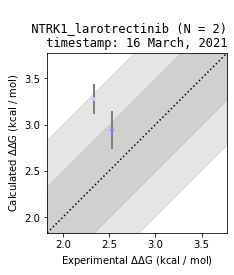

In [14]:
make_plot(
    dataframe=test_laro_df,
    target_name="NTRK1_larotrectinib",
    extra_name='flat',
    title=''
     )

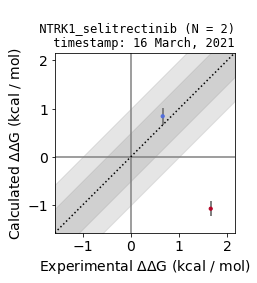

In [15]:
make_plot(
    dataframe=test_seli_df,
    target_name="NTRK1_selitrectinib",
    extra_name='flat',
    title=''
     )

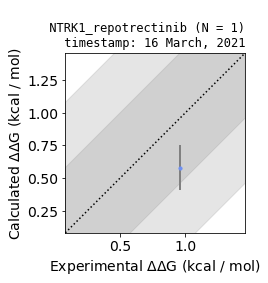

In [16]:
make_plot(
    dataframe=test_repo_df,
    target_name="NTRK1_repotrectinib",
    extra_name='flat',
    title=''
     )

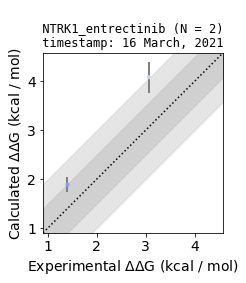

In [17]:
make_plot(
    dataframe=test_entr_df,
    target_name="NTRK1_entrectinib",
    extra_name='flat',
    title='',
     )

In [18]:
new_df = pd.concat([test_laro_df, test_seli_df, test_repo_df, test_entr_df])

saving figure...


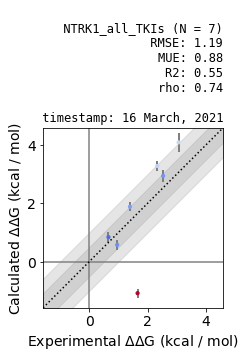

In [26]:
make_plot(
    dataframe=new_df,
    target_name="NTRK1_all_TKIs",
    extra_name='flat',
    title='',
    plot_stats=True,
    save=True,
    output_dir='/home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/'
     )

In [20]:
test_laro_df.insert(0, 'tki', "larotrectinib")
test_seli_df.insert(0, 'tki', "selitrectinib")
test_repo_df.insert(0, 'tki', "repotrectinib")
test_entr_df.insert(0, 'tki', "entrectinib")

In [21]:
new_df2 = pd.concat([test_laro_df, test_seli_df, test_repo_df, test_entr_df])

In [28]:
output_dir='/home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/'
new_df2.to_csv(f'{output_dir}NTRK1_resistance_results.csv')